# Calculation of detectable Gamma ray burst (GRB) event rate associated with Binary Neutron Star (BNS) mergers.

Analyst: [Hemanta Ph.](https://hemantaph.notion.site/Hemanta-Ph-b4c52e857d424c0db2a68f4e63d6097f), Anupreeta More, Otto Hannuksela.

Notes:

* This is without considering a particular detectors' sensitivity, but rather a general calculation of the rate of detectable GRBs based of viewing angle and luminosity distance. I have considered the inclination angle gravitational waves same as the viewing angle wrt GRB jet axis.

* It involves constructing Pdet (detection probability) function based off luminosity function.

* For BNS source redshift and mass distribution, refer [here](https://ler.readthedocs.io/en/latest/GW_events.html).

* For lens and image properties, refer [here](https://ler.readthedocs.io/en/latest/Lensed_events.html).

* Both SWIFT and FERMI detectors are considered.

* All analysis will be limited to redshift $z\in [0,5]$.

## Result summary

### Condition 1 (EM->GW)

Steps:
1. Sample GRB detectable events from BNS merger events.
2. Calculate rate
3. Check, out of these GRB detectable events, how many are detectable in GWs.

I will consider sub-threshold events as detectable (snr>6).

<!-- | Event | Unlensed | Lensed | Lensed:Unlensed |
| --- | --- | --- | --- |
| GRB | 11528.48 | 10.49 | 1:1099 |
| GW(snr>8) | 2.16 | 4.41e-3 | 1:489.8 |
| GW(snr>8):GRB | 1:5333.33 | 1:2380.95 | - |
| GW(snr>6) | 4.24 | 9.66e-3 | 1:438.92 |
| GW(snr>6):GRB | 1:2721.09 | 1:1086.96 | - | -->
| Event         | Unlensed  | Lensed    | Lensed:Unlensed |
| ---           | ---       | ---       | ---             |
| GRB           | 11543.22  | 10.60     | 1:1088.98       |
| GW(snr>8)     | 2.39      | 4.35e-3   | 1:549.42        |
| GW(snr>8):GRB | 1:4819.28 | 1:2439.02 | -               |
| GW(snr>6)     | 4.93      | 1.03e-2   | 1:478.64        |
| GW(snr>6):GRB | 1:2339.18 | 1:1030.93 | -               |

### Condition 2 (GW->EM)

Steps:
1. Sample GW detectable events from BNS merger events.
2. Calculate rate
3. Check, out of these GW detectable events, how many are detectable in GRBs.

I will consider super-threshold events only (snr>8).

<!-- | Event | Unlensed | Lensed | ratio[Unlensed/Lensed] |
| --- | --- | --- | --- |
| GW(snr>8) | 20 | 4.86e-2 | 1:411.52 |
| GRB (associated) | 1.82 | 3.93e-3 | 1:463.10 |
| ratio[GRB/GW(snr>8)] | 1:11 | 1:12.36 | - |
| GW(snr>6) | 46.8 | 1.36e-1 | 1:344.12 |
| GRB (associated) | 4.38 | 9.66e-3 | 1:453.42 |
| ratio[GRB/GW(snr>6)] | 1:10.68 | 1:14.11 | - | -->
<!-- | Event | Unlensed | Lensed | ratio[Unlensed/Lensed] |
| --- | --- | --- | --- |
| GW(snr>8) | 20.2 | 5.26e-2 | 1:384 |
| GRB (associated) | 1.81 | 3.63e-3 | 1:498.62 |
| GRB:GW(snr>8) | 1:11.12 | 1:14.48 | - | -->
| Event            | Unlensed | Lensed  | Lensed:Unlensed |
| ---              | ---      | ---     | ---             |
| GW(snr>8)        | 21.07    | 5.26e-2 | 1:400.57        |
| GRB (associated) | 1.91     | 3.99e-3 | 1:478.69        |
| GRB:GW(snr>8)    | 1:11.01  | 1:13.20 | -               |

# Combine plots (viewing angle vs redshift)

![Viewing angle vs Redshift](https://github.com/hemantaph/ler/blob/main/examples/rates/combined%20final.png)

## Equations (GRB)

* Ref: [Howell et. al. (2019)](https://arxiv.org/pdf/1811.09168)

* The luminosity function of GRBs is given by:

$$L(\theta_{V})=L_{c}\text{exp}(-\frac{\theta^{2}}{2\theta_{c}^{2}})$$

* Here, $L(\theta_{V})$ is the luminosity at viewing angle $\theta_{V}$, $L_{c}$ is the luminosity at the jet axis, $\theta$ is the viewing angle, and $\theta_{c}$ is the core angle of the jet.

* The paper gives: $\theta_{c} = 5$ degree.

* I will infer the probability of detection from the above equations.

$$P_{det}(\theta,D_L) = \left\{ 
  \begin{array}{ c l }
    1 & \text{if } \theta \le 5 \text{ deg and } D_L \le 46652 \text{ Mpc } (z\sim 5) \\
    1 & \text{if } \frac{\text{a}}{4\pi D_L^2} \text{exp}(-\frac{\theta^{2}}{2\times 21.2^2}) \ge 1 \\
    0 & \text{otherwise}
  \end{array}
\right.$$

* Coefficients a is solved by considering conditions 2 below,
  1. If angle <= 5 deg, distance <= distance_cut, then $P_{det}$ = 1.
  2. pdet=1, If angle=21.2 deg (at distance=40Mpc). This is by considering the GRB from GW170817 would have been difficult to detect if viewing angle>21.2 deg (at distance=40Mpc) or distance>40 Mpc (at angle=21.2 deg).

In [2]:
# calling the necessary libraries
from ler.rates import LeR
import numpy as np
# interpolate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from ler.utils import get_param_from_json

## Probability of detection of GRBs

### Finding the coefficients

In [3]:
import numpy as np
from scipy.optimize import fsolve

# to find coefficient a
# consider: pdet = 1, If angle = 21.2 deg (at distance=40). 
def equation(a):
    angle = 21.2
    distance = 40
    return a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/5)**2) - 1

a_guess = 10000

# Solve the equation
a_solution = fsolve(equation, a_guess)

print(f"a = {a_solution[0]}")

a = 161107621.34601912


### Function to calculate the probability of detection

In [4]:
# Find distance_cut
# convert redshift to luminoisty distance
import astropy.units as u
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
# let's assume z = 5 is the distance cut
z = 5
d_L = cosmo.luminosity_distance(z)
print(f"d_L = {d_L}")

d_L = 46652.22297277721 Mpc


In [5]:
class GRB:
    def __init__(self,
    z_min = 0, # minimum redshift
    z_max = 10, # maximum redshift 
    core_angle = 5, # core angle in degrees
    distance_cut = 46652.22297277721, # distance cut in Mpc for z=5
    cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7), # cosmology
    ):
        self.core_angle = core_angle
        self.distance_cut = distance_cut
        self.cosmo = cosmo
        self.coefficient = self.coefficient_finder()

        # interpolate and find luminosity distance to redshift conversion
        z = np.geomspace(z_min+0.0001, z_max, 10000)
        d_L = cosmo.luminosity_distance(z).value
        self.z_to_dl = interp1d(z, d_L, kind='cubic', fill_value='extrapolate')
        self.dl_to_z = interp1d(d_L, z, kind='cubic', fill_value='extrapolate')

    def coefficient_finder(self, a_guess = 10000):
        """
        Function to find the coefficient 'a' in the GRB pdet model.
        pdet = a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/5)**2){2\times 21.2^2})
        pdet = 1, If angle = 21.2 deg (at distance=40).

        Parameters
        ----------
        a_guess : float
            Initial guess for the coefficient 'a'
            default is 10000

        Returns
        -------
        float
            Coefficient 'a' in the GRB pdet model
        """
        def equation(a):
            # wrt to GW170817
            angle = 21.2
            distance = 40
            return a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/5)**2) - 1

        a_solution = fsolve(equation, a_guess)
        return a_solution[0]
    
    def pdet_grb(self, angle, distance, distance_cut=None, duty_cycle=0.5, mask_duty_cycle=True, bool=True, pdet_cut=1.):
        """
        Function to calculate the probability of detection for a given angle and distance (Mpc) for GRB. 

        Parameters
        ----------
        angle : numpy.ndarray
            Angle between the GRB jet and viewing angle in (rad)
        distance : numpy.ndarray
            Distance between the GRB source and the satellite in (Mpc)
        distance_cut : float
            Core angular size of the GRB jet in (rad)
            default is 25422.742 Mpc
        duty_cycle : float
            Duty cycle of detector(s)
            default is 0.5 (50%: for Fermi-GBM and Swift-BAT combined)
        bool : bool
            if True, return absolute value of pdet
            if False, return the pdet value as boolean (with duty cycle applied)

        Returns
        -------
        numpy.ndarray
            Probability of detection for a given angle and distance
        """

        a = self.coefficient
        jet_angle_cut = self.core_angle
        if distance_cut is None:
            distance_cut = self.distance_cut

        # make sure that the input data is a numpy array
        angle, distance = np.array([angle]).reshape(-1), np.array([distance]).reshape(-1)

        # angle should be less than 90 or equal to 90
        if len(angle[angle > 90]) > 0:
            angle[angle > 90] = angle[angle > 90]%90

        if bool:
            # calculate the probability of detection, absolute value
            pdet = abs(a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/jet_angle_cut)**2))

            # find idx of angle <= jet_angle_cut and distance <= distance_cut
            idx = (angle <= jet_angle_cut) & (distance <= distance_cut)
            # apply the condition, condition 1 from docstring
            pdet[idx] = 1

            # apply the duty cycle
            if mask_duty_cycle:
                # sample random numbers from 0 to 1 and check if it is less than the duty cycle
                num_ = np.random.rand(len(angle))
                mask_duty_cycle = num_ > duty_cycle
                pdet[mask_duty_cycle] = 0

            # return the pdet as boolean
            return (pdet>=pdet_cut).astype(int)
        else:
            # return the probability of detection (absolute value)
            return abs(a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/jet_angle_cut)**2))
    
    def pdet_calculator(self, gw_param_dict, duty_cycle=0.5, mask_duty_cycle=True, bool=True, pdet_cut=1.):
        """
        Pdet calculator for GRB. The  inputs and outputs are are compatible with ler package.

        Parameters
        ----------
        gw_param_dict : dict
            dictionary containing the parameters for the GW event
        duty_cycle : float
            Duty cycle of detector(s)
            default is 0.5 (50%: for Fermi-GBM and Swift-BAT combined)
        mask_duty_cycle : bool
            if True, apply the duty cycle
            default is True
        bool : bool
            if True, return absolute value of pdet
            if False, return the pdet value as boolean (with duty cycle applied)

        Returns
        -------
        dict
            dictionary containing the probability of detection for the given GW event
        """

        # get the angle and distance from the dictionary
        angle = np.degrees(gw_param_dict['theta_jn'])
        if 'luminosity_distance' in gw_param_dict:
            distance = gw_param_dict['luminosity_distance']
        elif 'effective_luminosity_distance' in gw_param_dict:
            distance = gw_param_dict['effective_luminosity_distance']

        # calculate the probability of detection
        pdet = self.pdet_grb(angle, distance, duty_cycle=duty_cycle, mask_duty_cycle=mask_duty_cycle, bool=bool, pdet_cut=pdet_cut)
        pdet_net_dict = dict(pdet_net=pdet)

        # return the pdet
        return pdet_net_dict

In [6]:
# class initialization
grb = GRB()

In [7]:
# test the pdet_grb function
angle = np.array([1, 1, 20, 90])
distance = np.array([46652, 46653, 40, 40])
print(grb.pdet_grb(angle, distance, mask_duty_cycle=False, bool=True))

[1 0 1 0]


In [8]:
# test the pdet_calculator function
gw_param_dict = {'theta_jn': np.radians(np.array([1, 21.2, 90])), 'luminosity_distance': np.array([2500, 40, 40])}
print(grb.pdet_calculator(gw_param_dict, mask_duty_cycle=False, bool=True))

{'pdet_net': array([1, 1, 0])}


### Plot detection and non-detection regions

In [9]:
# generate random data
angle = np.random.uniform(0, 30, 5000)
log10_distance = np.random.uniform(0, 5, 5000)
distance = 10**log10_distance
redshift = grb.dl_to_z(distance)

pdet = grb.pdet_grb(angle, distance, mask_duty_cycle=False, bool=True)

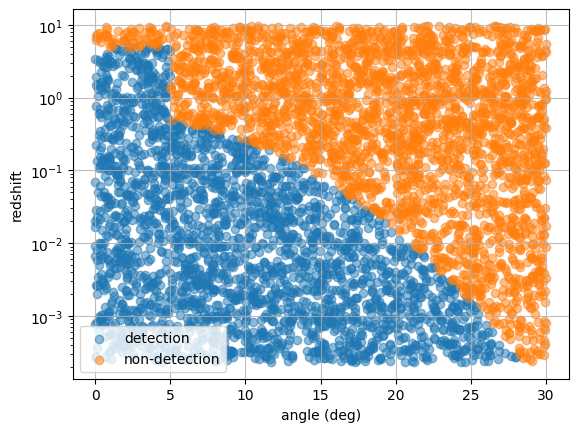

In [10]:
# blue: detection, red: non-detection
plt.scatter(angle[pdet==1], redshift[pdet==1], c='C0', label="detection", alpha=0.5)
plt.scatter(angle[pdet==0], redshift[pdet==0], c='C1', label="non-detection", alpha=0.5)

# draw a horizontal line for GW170817, 40Mpc
# plt.hlines(y=grb.dl_to_z(40), xmin=min(angle)-1, xmax=max(angle)+1, colors='C3', linestyles='solid', label='40Mpc, GW170817')

plt.xlabel("angle (deg)")
plt.ylabel("redshift")
plt.yscale("log")
plt.legend()
plt.grid(alpha=0.8)
plt.show()

## Rate calculation of GRB with LeR

All the necessary functions and parameters are defined below.

**Source related:**
* source frame mass: m1 and m2 sample from [double Gaussian](https://ler.readthedocs.io/en/latest/GW_events.html#BNS-mass-distribution:-Bimodal-Gaussian-Model) model lim[1,2.3]Mo
* Geocent time period: uniform prior, 1 year GPS: {'min_': 1238166018, 'max_': 1269702018}
* Redshift: 0 to 5, uniform, 
  * this follows [merger rate density distribution](https://ler.readthedocs.io/en/latest/GW_events.html#Merger-Rate-Density-Formula)
* ra:  sampler_uniform {'min_': 0.0, 'max_': 6.283185307179586}
* dec:  sampler_cosine [-np.pi/2, np.pi/2]
* phase : sampler_uniform {'min_': 0.0, 'max_': 6.283185307179586}
* psi: sampler_uniform {'min_': 0.0, 'max_': 3.141592653589793}
* theta_jn: sampler_uniform {'min_': 0.0, 'max_': 3.141592653589793}

**Lens related**
* Optical depth: SIE , 
  * so zs for lensed are rejection sampled with optical depth. 
* Lens redshifts: SDSS catalogue (0 to zs), the function of zs Reenske et al. 2021 ( eqnC13). [`ler` function](https://github.com/hemantaph/ler/blob/bce3330638a13ee0883d19633abb17b98791c901/ler/lens_galaxy_population/jit_functions.py#L218)
* Velocity dispersion: gengamma, Haris et al 2018, a=2.32 / 2.67, c=2.67, vd_min=0., vd_max=600.(https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gengamma.html) use in Haris et al upto zs~1.5 (with a=2.32 / 2.67, c=2.67)
* Axis ratio: Raleigh (with Velocity dispersion dependence) {'q_min': 0.2, 'q_max': 1.0}
* axis_rotation_angle : uniform {'phi_min': 0.0, 'phi_max': 6.283185307179586}
* shear: normal {'scale': 0.05}
* mass_density_spectral_index: normal {'mean': 2.0, 'std': 0.2}

**Image related:**
* Strong lensing condition: num_images>=2
* Lens equation solver: EPL+Shear, `lenstronomy`
* Source position: sample within caustic,  Ewoud et. al. 2022

In [11]:
ler = LeR(
    npool=8,
    verbose=False,
    z_max=10,
    pdet_finder=grb.pdet_calculator,
    source_priors={'theta_jn': 'sampler_uniform',},
    source_priors_params={'theta_jn': {'min_': 0, 'max_': np.pi},},
    event_type='BNS',
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

### Unlensed events

In [14]:
unlensed_param_detectable = ler.selecting_n_unlensed_detectable_events(
    size=400000,
    batch_size=200000,
    resume=True,
    trim_to_size=True,
    detectability_condition="pdet",
    output_jsonfile="n_unlensed_params_detectable_grb2.json",
    meta_data_file="meta_unlensed_grb2.json",
)

collected number of detectable events =  0
collected number of detectable events =  5097
total number of events =  200000
total unlensed rate (yr^-1): 11645.968515441678
collected number of detectable events =  10182
total number of events =  400000
total unlensed rate (yr^-1): 11632.259311774294
collected number of detectable events =  15039
total number of events =  600000
total unlensed rate (yr^-1): 11454.039664098318
collected number of detectable events =  19976
total number of events =  800000
total unlensed rate (yr^-1): 11410.627185818272
collected number of detectable events =  25179
total number of events =  1000000
total unlensed rate (yr^-1): 11506.134638034373
collected number of detectable events =  30241
total number of events =  1200000
total unlensed rate (yr^-1): 11516.111891814522
collected number of detectable events =  35424
total number of events =  1400000
total unlensed rate (yr^-1): 11562.734064603996
collected number of detectable events =  40394
total number

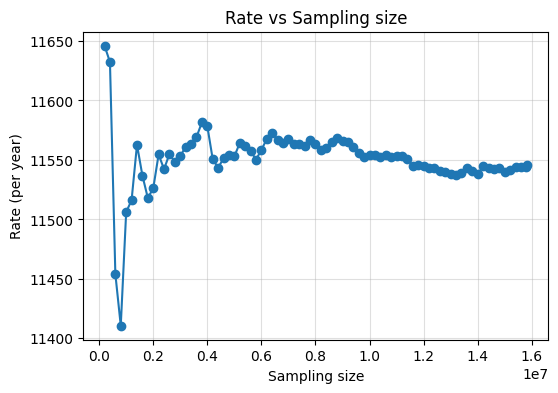

In [15]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_unlensed_grb2.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [16]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 1.4e7)[0]
# take average 
grb_rate_unlensed1 = np.mean(meta_data['total_rate'][idx])
print('Unlensed GRB Rate (per year) =', grb_rate_unlensed1)

Unlensed GRB Rate (per year) = 11543.221199013773


### Checking how many of these events are detectable in GWs

In [17]:
# gwsnr will be used to calculate the SNR of the associated GW event
ler = LeR(
    verbose=False,
    z_max=10,
    event_type='BNS',
    source_priors={'theta_jn': 'sampler_uniform',},
    source_priors_params={'theta_jn': {'min_': 0, 'max_': np.pi},},
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

In [18]:
# get the generated unlensed parameters
unlensed_param_detectable = get_param_from_json("ler_data/n_unlensed_params_detectable_grb2.json")
# calculate the SNR of the associated GW event
snr_unlensed = ler.snr(gw_param_dict=unlensed_param_detectable)['optimal_snr_net']

In [19]:
# super-threshold only
# number of detectable events in terms of GW snr out of already detected events in term of GRB pdet
print(f"Number of unlensed detectable events in terms of GW snr is {np.sum(snr_unlensed>8)} \nout of {len(snr_unlensed)} events that are already detected in terms of GRB pdet\n")

print(f"if the rate of detectable unlensed GRBs is {grb_rate_unlensed1}, \nthen the rate of detectable GWs is {grb_rate_unlensed1*np.sum(snr_unlensed>8)/len(snr_unlensed)}\n")

print(f"ratio (unlensed detectable GRBs)/(unlensed detectable GWs) = {len(snr_unlensed)/np.sum(snr_unlensed>8)}")

Number of unlensed detectable events in terms of GW snr is 83 
out of 400000 events that are already detected in terms of GRB pdet

if the rate of detectable unlensed GRBs is 11543.221199013773, 
then the rate of detectable GWs is 2.395218398795358

ratio (unlensed detectable GRBs)/(unlensed detectable GWs) = 4819.277108433735


In [20]:
# sub-threshold considered
# number of detectable events in terms of GW snr out of already detected events in term of GRB pdet
print(f"Number of unlensed detectable events in terms of GW snr is {np.sum(snr_unlensed>6)} \nout of {len(snr_unlensed)} events that are already detected in terms of GRB pdet\n")

print(f"if the rate of detectable unlensed GRBs is {grb_rate_unlensed1}, \nthen the rate of detectable GWs is {grb_rate_unlensed1*np.sum(snr_unlensed>6)/len(snr_unlensed)}\n")

print(f"ratio (unlensed detectable GRBs)/(unlensed detectable GWs) = {len(snr_unlensed)/np.sum(snr_unlensed>6)}")

Number of unlensed detectable events in terms of GW snr is 171 
out of 400000 events that are already detected in terms of GRB pdet

if the rate of detectable unlensed GRBs is 11543.221199013773, 
then the rate of detectable GWs is 4.934727062578388

ratio (unlensed detectable GRBs)/(unlensed detectable GWs) = 2339.1812865497077


### Lensed events

In [21]:
ler = LeR(
    npool=8,
    verbose=False,
    z_max=10,
    pdet_finder=grb.pdet_calculator,
    source_priors={'theta_jn': 'sampler_uniform',},
    source_priors_params={'theta_jn': {'min_': 0, 'max_': np.pi},},
    event_type='BNS',
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

In [22]:
lensed_param_detectable = ler.selecting_n_lensed_detectable_events(
    size=100000,
    batch_size=200000,
    # snr_threshold=[8.0,8.0],
    # num_img=[1,1],
    resume=True,
    trim_to_size=True,
    detectability_condition="pdet",
    output_jsonfile="n_lensed_params_detectable_grb2.json",
    meta_data_file="meta_lensed_grb2.json",
)

collected number of detectable events =  0


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


collected number of detectable events =  2137
total number of events =  200000
total lensed rate (yr^-1): 10.705359677118846


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.36it/s]


collected number of detectable events =  4239
total number of events =  400000
total lensed rate (yr^-1): 10.617692950703507


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.67s/it]


collected number of detectable events =  6413
total number of events =  600000
total lensed rate (yr^-1): 10.708699361934668


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.13s/it]


collected number of detectable events =  8532
total number of events =  800000
total lensed rate (yr^-1): 10.68532156822391


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


collected number of detectable events =  10610
total number of events =  1000000
total lensed rate (yr^-1): 10.63021676876284


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


collected number of detectable events =  12711
total number of events =  1200000
total lensed rate (yr^-1): 10.612683423479773


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.30s/it]


collected number of detectable events =  14767
total number of events =  1400000
total lensed rate (yr^-1): 10.567955501839293


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.78it/s]


collected number of detectable events =  16956
total number of events =  1600000
total lensed rate (yr^-1): 10.617692950703507


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.37it/s]


collected number of detectable events =  19066
total number of events =  1800000
total lensed rate (yr^-1): 10.612405116411788


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s]


collected number of detectable events =  21156
total number of events =  2000000
total lensed rate (yr^-1): 10.598155794530944


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.96it/s]


collected number of detectable events =  23327
total number of events =  2200000
total lensed rate (yr^-1): 10.62338559527593


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.36it/s]


collected number of detectable events =  25412
total number of events =  2400000
total lensed rate (yr^-1): 10.608508817459995


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.99it/s]


collected number of detectable events =  27535
total number of events =  2600000
total lensed rate (yr^-1): 10.610564008115885


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.29it/s]


collected number of detectable events =  29618
total number of events =  2800000
total lensed rate (yr^-1): 10.598012665181695


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]


collected number of detectable events =  31676
total number of events =  3000000
total lensed rate (yr^-1): 10.578785622599174


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.05s/it]


collected number of detectable events =  33822
total number of events =  3200000
total lensed rate (yr^-1): 10.589514360070005


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.68it/s]


collected number of detectable events =  35905
total number of events =  3400000
total lensed rate (yr^-1): 10.580416174597488


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.53it/s]


collected number of detectable events =  38023
total number of events =  3600000
total lensed rate (yr^-1): 10.5820696460014


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.40it/s]


collected number of detectable events =  40122
total number of events =  3800000
total lensed rate (yr^-1): 10.578539540560115


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]


collected number of detectable events =  42238
total number of events =  4000000
total lensed rate (yr^-1): 10.57962054380313


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]


collected number of detectable events =  44396
total number of events =  4200000
total lensed rate (yr^-1): 10.590617648803804


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]


collected number of detectable events =  46611
total number of events =  4400000
total lensed rate (yr^-1): 10.613594246611362


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]


collected number of detectable events =  48743
total number of events =  4600000
total lensed rate (yr^-1): 10.61649502028044


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.88it/s]


collected number of detectable events =  50783
total number of events =  4800000
total lensed rate (yr^-1): 10.59995087511945


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


collected number of detectable events =  52858
total number of events =  5000000
total lensed rate (yr^-1): 10.591743599684566


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.08s/it]


collected number of detectable events =  55026
total number of events =  5200000
total lensed rate (yr^-1): 10.602086346660336


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


collected number of detectable events =  57092
total number of events =  5400000
total lensed rate (yr^-1): 10.5927380836075


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.80it/s]


collected number of detectable events =  59288
total number of events =  5600000
total lensed rate (yr^-1): 10.607316072882915


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.14it/s]


collected number of detectable events =  61368
total number of events =  5800000
total lensed rate (yr^-1): 10.600850574692679


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


collected number of detectable events =  63542
total number of events =  6000000
total lensed rate (yr^-1): 10.610512628349488


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.47it/s]


collected number of detectable events =  65688
total number of events =  6200000
total lensed rate (yr^-1): 10.615026589439262


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.24it/s]


collected number of detectable events =  67802
total number of events =  6400000
total lensed rate (yr^-1): 10.61424890073719


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.38it/s]


collected number of detectable events =  69901
total number of events =  6600000
total lensed rate (yr^-1): 10.61124128685476


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


collected number of detectable events =  72004
total number of events =  6800000
total lensed rate (yr^-1): 10.608999947579967


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


collected number of detectable events =  74175
total number of events =  7000000
total lensed rate (yr^-1): 10.616619480584136


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.85it/s]


collected number of detectable events =  76248
total number of events =  7200000
total lensed rate (yr^-1): 10.610178659867906


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


collected number of detectable events =  78331
total number of events =  7400000
total lensed rate (yr^-1): 10.60543991789951


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.40it/s]


collected number of detectable events =  80499
total number of events =  7600000
total lensed rate (yr^-1): 10.612156104824644


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


collected number of detectable events =  82614
total number of events =  7800000
total lensed rate (yr^-1): 10.611720052859823


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.21it/s]


collected number of detectable events =  84651
total number of events =  8000000
total lensed rate (yr^-1): 10.601537225406965


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.85it/s]


collected number of detectable events =  86714
total number of events =  8200000
total lensed rate (yr^-1): 10.595027894605881


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.15it/s]


collected number of detectable events =  88936
total number of events =  8400000
total lensed rate (yr^-1): 10.607793170713746


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]


collected number of detectable events =  91036
total number of events =  8600000
total lensed rate (yr^-1): 10.605751635809723


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.84it/s]


collected number of detectable events =  93102
total number of events =  8800000
total lensed rate (yr^-1): 10.599931899637541


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.77it/s]


collected number of detectable events =  95324
total number of events =  9000000
total lensed rate (yr^-1): 10.611737179448623


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.19it/s]


collected number of detectable events =  97356
total number of events =  9200000
total lensed rate (yr^-1): 10.602337660735106


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


collected number of detectable events =  99512
total number of events =  9400000
total lensed rate (yr^-1): 10.606554746557121


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.07it/s]


collected number of detectable events =  101665
total number of events =  9600000
total lensed rate (yr^-1): 10.6102830250184
storing detectable lensed params in ./ler_data/n_lensed_params_detectable_grb2.json
storing meta data in ./ler_data/meta_lensed_grb2.json

 trmming final result to size=100000
collected number of detectable events =  100000
total number of events =  9442778.0
total unlensed rate (yr^-1): 10.610282744619575


In [23]:
# lensed_param_detectable = get_param_from_json("ler_data/n_lensed_params_detectable_grb2.json")
# zs = lensed_param_detectable['zs']
# viewing_angle = lensed_param_detectable['theta_jn']
# # radian to degree
# viewing_angle = np.degrees(viewing_angle)
# # if angle > 90, then angle = 180 - angle
# viewing_angle[viewing_angle > 90] = viewing_angle[viewing_angle > 90]-90

# # blue: detection, red: non-detection
# plt.scatter(viewing_angle, zs, c='C0', label="detection", alpha=0.5)

# # draw a horizontal line for GW170817, 40Mpc
# # plt.hlines(y=dl_to_z(40), xmin=min(angle)-1, xmax=max(angle)+1, colors='C3', linestyles='solid', label='40Mpc, GW170817')

# plt.xlabel("viewing angle (deg)")
# plt.ylabel("redshiift")
# plt.yscale("log")
# plt.legend()
# plt.grid(alpha=0.8)
# plt.show()

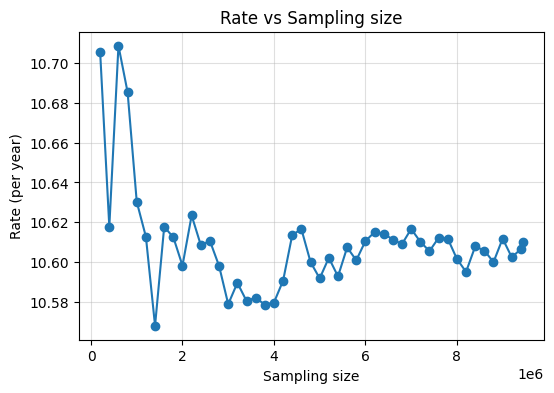

In [24]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_lensed_grb2.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [25]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 3e6)[0]
# take average 
grb_rate_lensed1 = np.mean(meta_data['total_rate'][idx])
print('Lensed GRB Rate (per year) =', grb_rate_lensed1)

Lensed GRB Rate (per year) = 10.602504559391095


### Out of the detected GRB events, how many are detectable in GW.

* find out GW detector SNRs of the event which are detectable in GRBs.

* check how many of them cross the SNR threshold

In [26]:
# ler initialization with default snr calculator (gwsnr)
ler = LeR(
    verbose=False,
    z_max=5,
    event_type='BNS',
    source_priors={'theta_jn': 'sampler_uniform',},
    source_priors_params={'theta_jn': {'min_': 0, 'max_': np.pi},},
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

In [27]:
# get snr for the lensed events
lensed_param_detectable = get_param_from_json("ler_data/n_lensed_params_detectable_grb2.json")
snr_lensed, _ = ler.get_lensed_snrs(lensed_param_detectable, list_of_detectors=['L1','H1','V1'], snr_calculator=ler.snr)
snr_lensed = snr_lensed['optimal_snr_net']

In [28]:
# only super-threshold events
num_ =  np.sum(np.sum(snr_lensed>8, axis=1)>=2)
print(f"Number of lensed detectable events in terms of GW snr is {num_} out of {len(snr_lensed)} \nevents that are already detected in terms of GRB pdet\n")

print(f"if the rate of detectable lensed GRBs is {grb_rate_lensed1}, \nthen the rate of detectable GWs is {grb_rate_lensed1*num_/len(snr_lensed)}\n")

print(f"ratio (lensed detectable GRBs)/(lensed detectable GWs) = {len(snr_lensed)/num_}")

Number of lensed detectable events in terms of GW snr is 41 out of 100000 
events that are already detected in terms of GRB pdet

if the rate of detectable lensed GRBs is 10.602504559391095, 
then the rate of detectable GWs is 0.004347026869350349

ratio (lensed detectable GRBs)/(lensed detectable GWs) = 2439.0243902439024


In [29]:
# sub-threshold events considered
num_ =  np.sum(np.sum(snr_lensed>6, axis=1)>=2)
print(f"Number of lensed detectable events in terms of GW snr is {num_} out of {len(snr_lensed)} \nevents that are already detected in terms of GRB pdet\n")

print(f"if the rate of detectable lensed GRBs is {grb_rate_lensed1}, \nthen the rate of detectable GWs is {grb_rate_lensed1*num_/len(snr_lensed)}\n")

print(f"ratio (lensed detectable GRBs)/(lensed detectable GWs) = {len(snr_lensed)/num_}")

Number of lensed detectable events in terms of GW snr is 97 out of 100000 
events that are already detected in terms of GRB pdet

if the rate of detectable lensed GRBs is 10.602504559391095, 
then the rate of detectable GWs is 0.010284429422609362

ratio (lensed detectable GRBs)/(lensed detectable GWs) = 1030.9278350515465


### Detector horizon calculation for BNS

In [30]:
from gwsnr import GWSNR
gwsnr = GWSNR(
    mtot_max=51,
    ifos=['L1','H1','V1'],
    gwsnr_verbose=False,
)

Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_4.pickle


In [31]:
dhor = gwsnr.detector_horizon(mass_1=1.4, mass_2=1.4, snr_th=6, snr_th_net=6)['net'][0]
print(f"Detector Horizon for BNS at SNR=6 is {dhor} Mpc")

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.84s/it]


dl_eff 389.5713941459235
optimal_snr_unscaled [32.91841147]
Detector Horizon for BNS at SNR=6 is 2137.345241875989 Mpc


## Plot (GRB with associated GW)

In [82]:
# This will be used to plot the viewing angle vs redshift
unlensed_param_detectable = get_param_from_json("ler_data/n_unlensed_params_detectable_grb2.json")
zs_grb_unlensed = unlensed_param_detectable['zs']
viewing_angle_grb_unlensed = unlensed_param_detectable['theta_jn']
# radian to degree
viewing_angle_grb_unlensed = np.degrees(viewing_angle_grb_unlensed)
# if angle > 90, then angle = 180 - angle
viewing_angle_grb_unlensed[viewing_angle_grb_unlensed > 90] = viewing_angle_grb_unlensed[viewing_angle_grb_unlensed > 90]-90

In [83]:
lensed_param_detectable = get_param_from_json("ler_data/n_lensed_params_detectable_grb2.json")
zs_grb_lensed = lensed_param_detectable['zs']
viewing_angle_grb_lensed = lensed_param_detectable['theta_jn']
# radian to degree
viewing_angle_grb_lensed = np.degrees(viewing_angle_grb_lensed)
# if angle > 90, then angle = 180 - angle
viewing_angle_grb_lensed[viewing_angle_grb_lensed > 90] = viewing_angle_grb_lensed[viewing_angle_grb_lensed > 90]-90

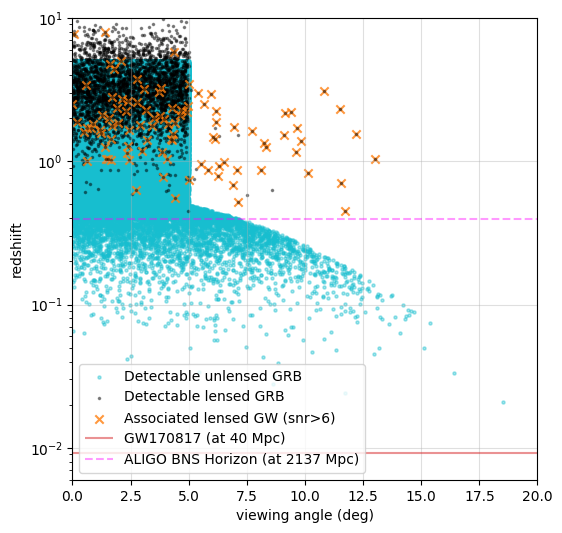

In [84]:
# blue: detection, red: non-detection
num_ = np.round(len(viewing_angle_grb_lensed)/30)
idx_ = np.random.choice(len(viewing_angle_grb_lensed), int(num_), replace=False)

plt.figure(figsize=(6,6))

# unlensed GRB
plt.scatter(viewing_angle_grb_unlensed, zs_grb_unlensed, c='C9', label="Detectable unlensed GRB", alpha=0.4, marker='.', s=20)

# lensed GRB
plt.scatter(viewing_angle_grb_lensed[idx_], zs_grb_lensed[idx_], c='k', label="Detectable lensed GRB", alpha=0.4, marker='.', s=10)

# lensed GW, only snr_lensed>6
idx_ = np.sum(snr_lensed>6, axis=1)>=2
plt.scatter(viewing_angle_grb_lensed[idx_], zs_grb_lensed[idx_], c='C1', label="Associated lensed GW (snr>6)", alpha=0.8, marker='x')
plt.scatter(viewing_angle_grb_lensed[idx_], zs_grb_lensed[idx_], c='k', alpha=0.4, marker='.', s=10)

# unlensed GW, only snr_unlensed>6
# idx_ = snr_unlensed>6
# plt.scatter(viewing_angle_grb_unlensed[idx_], zs_grb_unlensed[idx_], c='r', label="Associated unlensed GW (snr>6)", alpha=0.8, marker='x')
# plt.scatter(viewing_angle_grb_unlensed[idx_], zs_grb_unlensed[idx_], c='C9', alpha=0.9, marker='.', s=10)

# draw a horizontal line for GW170817, 40Mpc
plt.hlines(y=grb.dl_to_z(40), xmin=0, xmax=20, colors='C3', linestyles='solid', label='GW170817 (at 40 Mpc)', alpha=0.5)

# dhor 
plt.hlines(y=grb.dl_to_z(2137), xmin=0, xmax=20, colors='magenta', linestyles='dashed', label="ALIGO BNS Horizon (at 2137 Mpc)", alpha=0.4)

plt.xlabel("viewing angle (deg)")
plt.ylabel("redshiift")
#plt.title("Detectable GRB vs associated detectable GW")
plt.yscale("log")
plt.xlim(0., 20)
plt.ylim(0.006, 10)
plt.legend(loc='lower left')
plt.grid(alpha=0.4)
# save the plot
plt.savefig("grb with associated gw final.png", dpi=400)
plt.show()

### Table for GRB rates and associate GW rates

| Event         | Unlensed  | Lensed    | Lensed:Unlensed |
| ---           | ---       | ---       | ---             |
| GRB           | 11543.22  | 10.60     | 1:1088.98       |
| GW(snr>8)     | 2.39      | 4.35e-3   | 1:549.42        |
| GW(snr>8):GRB | 1:4819.28 | 1:2439.02 | -               |
| GW(snr>6)     | 4.93      | 1.03e-2   | 1:478.64        |
| GW(snr>6):GRB | 1:2339.18 | 1:1030.93 | -               |

Remarks

- GRB rate: 1 lensed GRB out of 1099  GRBs
- GW rate: 1 lensed GW(snr>6) out of 1087 lensed GRBs, i.e. 1 lensed GW out of 1194613 unlensed GRBs
- We might need push the SNR threshold further down to get more lensed GWs.
- But for the unlensed GWs, the rate is 1 GW(snr>6) out of 2721 unlensed GRBs, which is not bad for the current detection capability.

## Case II: GW detection first

# Unlensed events

In [35]:
ler = LeR(
    verbose=False,
    z_max=10,
    event_type='BNS',
    source_priors={'theta_jn': 'sampler_uniform',},
    source_priors_params={'theta_jn': {'min_': 0, 'max_': np.pi},},
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

In [36]:
unlensed_param_detectable = ler.selecting_n_unlensed_detectable_events(
    size=5000,
    batch_size=200000,
    snr_threshold=8.0,
    resume=True,
    trim_to_size=True,
    output_jsonfile="n_unlensed_params_detectable_gw_super2.json",
    meta_data_file="meta_unlensed_gw_super2.json",
)

collected number of detectable events =  0
collected number of detectable events =  9
total number of events =  200000
total unlensed rate (yr^-1): 20.563805501074178
collected number of detectable events =  17
total number of events =  400000
total unlensed rate (yr^-1): 19.421371862125614
collected number of detectable events =  26
total number of events =  600000
total unlensed rate (yr^-1): 19.80218307510847
collected number of detectable events =  33
total number of events =  800000
total unlensed rate (yr^-1): 18.85015504265133
collected number of detectable events =  45
total number of events =  1000000
total unlensed rate (yr^-1): 20.56380550107418
collected number of detectable events =  52
total number of events =  1200000
total unlensed rate (yr^-1): 19.80218307510847
collected number of detectable events =  57
total number of events =  1400000
total unlensed rate (yr^-1): 18.60534783430521
collected number of detectable events =  64
total number of events =  1600000
total u

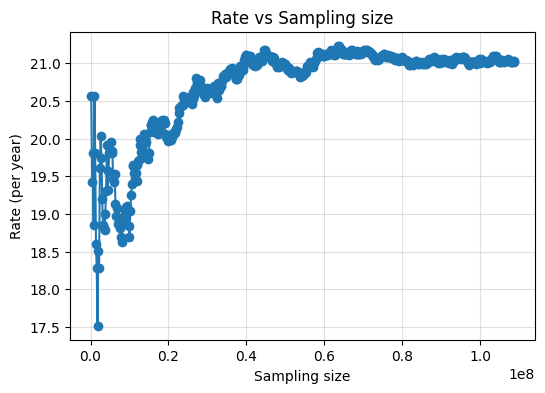

In [37]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_unlensed_gw_super2.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [38]:
# select only events after sampling size of
idx = np.where(meta_data['events_total'] > 0.6e8)[0]
# take average
gw_rate_unlensed = np.mean(meta_data['total_rate'][idx])
print('Unlensed GW Rate (per year) =', gw_rate_unlensed)

Unlensed GW Rate (per year) = 21.066301441939544


### How many detectable events are there in terms of GRB pdet out of already detected events in terms of GW snr?

In [39]:
unlensed_param_detectable = get_param_from_json('./ler_data/n_unlensed_params_detectable_gw_super2.json')
unlensed_grb_pdet = grb.pdet_calculator(unlensed_param_detectable)

In [40]:
# number of detectable events in terms of GRB pdet out of already detected events in term of GW snr
print(f"Number of unlensed detectable events in terms of GRB pdet is {np.sum(unlensed_grb_pdet['pdet_net']==1)} \nout of {len(unlensed_grb_pdet['pdet_net'])} events that are already detected in terms of GW snr\n")

print(f"if the rate of detectable unlensed GWs is {gw_rate_unlensed}, \nthen the rate of detectable GRBs is {gw_rate_unlensed*np.sum(unlensed_grb_pdet['pdet_net']==1)/len(unlensed_grb_pdet['pdet_net'])}\n")

print(f"ratio (unlensed detectable GWs)/(unlensed detectable GRBs) = {len(unlensed_grb_pdet['pdet_net'])/np.sum(unlensed_grb_pdet['pdet_net']==1)}")

Number of unlensed detectable events in terms of GRB pdet is 454 
out of 5000 events that are already detected in terms of GW snr

if the rate of detectable unlensed GWs is 21.066301441939544, 
then the rate of detectable GRBs is 1.9128201709281107

ratio (unlensed detectable GWs)/(unlensed detectable GRBs) = 11.013215859030836


### Lensed events

In [41]:
ler = LeR(
    npool=8,
    verbose=False,
    z_max=10,
    event_type='BNS',
    source_priors={'theta_jn': 'sampler_uniform',},
    source_priors_params={'theta_jn': {'min_': 0, 'max_': np.pi},},
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

In [42]:
# super-threshold events considered
lensed_param_detectable = ler.selecting_n_lensed_detectable_events(
    size=20000,
    batch_size=200000,
    snr_threshold=[8.0,8.0],
    num_img=[1,1],
    resume=True,
    output_jsonfile="n_lensed_params_detectable_gw_super2.json",
    meta_data_file="meta_lensed_gw_super2.json",
)

collected number of detectable events =  0


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.47it/s]


collected number of detectable events =  17
total number of events =  200000
total lensed rate (yr^-1): 0.08516196280347234


100%|███████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.03it/s]


collected number of detectable events =  24
total number of events =  400000
total lensed rate (yr^-1): 0.060114326684804


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.72it/s]


collected number of detectable events =  31
total number of events =  600000
total lensed rate (yr^-1): 0.051765114645247884


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.50s/it]


collected number of detectable events =  44
total number of events =  800000
total lensed rate (yr^-1): 0.05510479946107033


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.99it/s]


collected number of detectable events =  49
total number of events =  1000000
total lensed rate (yr^-1): 0.04909336679258994


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.53it/s]


collected number of detectable events =  57
total number of events =  1200000
total lensed rate (yr^-1): 0.04759050862546983


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]


collected number of detectable events =  65
total number of events =  1400000
total lensed rate (yr^-1): 0.046517038506098334


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.59it/s]


collected number of detectable events =  79
total number of events =  1600000
total lensed rate (yr^-1): 0.04946908133436996


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]


collected number of detectable events =  91
total number of events =  1800000
total lensed rate (yr^-1): 0.05065188637330708


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.75it/s]


collected number of detectable events =  103
total number of events =  2000000
total lensed rate (yr^-1): 0.051598130404456766


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


collected number of detectable events =  120
total number of events =  2200000
total lensed rate (yr^-1): 0.05464938789527636


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


collected number of detectable events =  131
total number of events =  2400000
total lensed rate (yr^-1): 0.05468733885909252


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.22it/s]


collected number of detectable events =  141
total number of events =  2600000
total lensed rate (yr^-1): 0.05433410296511131


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.46it/s]


collected number of detectable events =  148
total number of events =  2800000
total lensed rate (yr^-1): 0.05295785922232733


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.85it/s]


collected number of detectable events =  158
total number of events =  3000000
total lensed rate (yr^-1): 0.05276702008999462


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


collected number of detectable events =  162
total number of events =  3200000
total lensed rate (yr^-1): 0.050721463140303374


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


collected number of detectable events =  167
total number of events =  3400000
total lensed rate (yr^-1): 0.04921123802138366


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.98it/s]


collected number of detectable events =  175
total number of events =  3600000
total lensed rate (yr^-1): 0.04870373689741065


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


collected number of detectable events =  185
total number of events =  3800000
total lensed rate (yr^-1): 0.04877697559951202


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.97it/s]


collected number of detectable events =  199
total number of events =  4000000
total lensed rate (yr^-1): 0.04984479587614998


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.96it/s]


collected number of detectable events =  212
total number of events =  4200000
total lensed rate (yr^-1): 0.05057237006816845


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.93it/s]


collected number of detectable events =  226
total number of events =  4400000
total lensed rate (yr^-1): 0.05146150693471858


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.84it/s]


collected number of detectable events =  233
total number of events =  4600000
total lensed rate (yr^-1): 0.05074868883173671


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.19it/s]


collected number of detectable events =  245
total number of events =  4800000
total lensed rate (yr^-1): 0.05113892374228118


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.38it/s]


collected number of detectable events =  252
total number of events =  5000000
total lensed rate (yr^-1): 0.05049603441523536


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.80it/s]


collected number of detectable events =  264
total number of events =  5200000
total lensed rate (yr^-1): 0.05086596873329569


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.15it/s]


collected number of detectable events =  271
total number of events =  5400000
total lensed rate (yr^-1): 0.050280810282660134


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.85it/s]


collected number of detectable events =  284
total number of events =  5600000
total lensed rate (yr^-1): 0.050810918983584336


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.67it/s]


collected number of detectable events =  291
total number of events =  5800000
total lensed rate (yr^-1): 0.05026801455539645


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.93it/s]


collected number of detectable events =  308
total number of events =  6000000
total lensed rate (yr^-1): 0.05143114616366564


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.86it/s]


collected number of detectable events =  323
total number of events =  6200000
total lensed rate (yr^-1): 0.05219604171825724


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]


collected number of detectable events =  330
total number of events =  6400000
total lensed rate (yr^-1): 0.05166074949475344


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


collected number of detectable events =  334
total number of events =  6600000
total lensed rate (yr^-1): 0.050702487658395294


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.69it/s]


collected number of detectable events =  346
total number of events =  6800000
total lensed rate (yr^-1): 0.05097930645328967


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.83it/s]


collected number of detectable events =  358
total number of events =  7000000
total lensed rate (yr^-1): 0.05124030703133293


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.82it/s]


collected number of detectable events =  369
total number of events =  7200000
total lensed rate (yr^-1): 0.05134765404327009


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.37it/s]


collected number of detectable events =  381
total number of events =  7400000
total lensed rate (yr^-1): 0.051584591141689916


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


collected number of detectable events =  390
total number of events =  7600000
total lensed rate (yr^-1): 0.05141356887516131


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54it/s]


collected number of detectable events =  400
total number of events =  7800000
total lensed rate (yr^-1): 0.05137976639726838


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]


collected number of detectable events =  406
total number of events =  8000000
total lensed rate (yr^-1): 0.05084670132089672


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.66s/it]


collected number of detectable events =  417
total number of events =  8200000
total lensed rate (yr^-1): 0.05095055737309607


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


collected number of detectable events =  426
total number of events =  8400000
total lensed rate (yr^-1): 0.050810918983584336


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]


collected number of detectable events =  438
total number of events =  8600000
total lensed rate (yr^-1): 0.05102727730221735


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.53it/s]


collected number of detectable events =  449
total number of events =  8800000
total lensed rate (yr^-1): 0.051119948260373096


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


collected number of detectable events =  460
total number of events =  9000000
total lensed rate (yr^-1): 0.051208500509277485


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.39it/s]


collected number of detectable events =  471
total number of events =  9200000
total lensed rate (yr^-1): 0.051293202660403416


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.74it/s]


collected number of detectable events =  481
total number of events =  9400000
total lensed rate (yr^-1): 0.051267714779061564


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.22it/s]


collected number of detectable events =  496
total number of events =  9600000
total lensed rate (yr^-1): 0.051765114645247884


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


collected number of detectable events =  506
total number of events =  9800000
total lensed rate (yr^-1): 0.05173103622875991


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


collected number of detectable events =  520
total number of events =  10000000
total lensed rate (yr^-1): 0.052099083126830134


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


collected number of detectable events =  528
total number of events =  10200000
total lensed rate (yr^-1): 0.05186334066924267


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.21it/s]


collected number of detectable events =  537
total number of events =  10400000
total lensed rate (yr^-1): 0.0517330022912496


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]


collected number of detectable events =  548
total number of events =  10600000
total lensed rate (yr^-1): 0.051796621105774515


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.45it/s]


collected number of detectable events =  563
total number of events =  10800000
total lensed rate (yr^-1): 0.05222895975855656


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.11it/s]


collected number of detectable events =  577
total number of events =  11000000
total lensed rate (yr^-1): 0.052554494692624104


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.55it/s]


collected number of detectable events =  584
total number of events =  11200000
total lensed rate (yr^-1): 0.052242212476079665


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]


collected number of detectable events =  595
total number of events =  11400000
total lensed rate (yr^-1): 0.05229243330037775


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.11it/s]


collected number of detectable events =  605
total number of events =  11600000
total lensed rate (yr^-1): 0.052254551213083936


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.27it/s]


collected number of detectable events =  615
total number of events =  11800000
total lensed rate (yr^-1): 0.052217953264342455


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]


collected number of detectable events =  625
total number of events =  12000000
total lensed rate (yr^-1): 0.05218257524722569


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]


collected number of detectable events =  634
total number of events =  12200000
total lensed rate (yr^-1): 0.05206623376798598


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.55it/s]


collected number of detectable events =  649
total number of events =  12400000
total lensed rate (yr^-1): 0.052438438196825


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]


collected number of detectable events =  663
total number of events =  12600000
total lensed rate (yr^-1): 0.052719310306911446


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.24it/s]


collected number of detectable events =  675
total number of events =  12800000
total lensed rate (yr^-1): 0.05283485743781602


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]


collected number of detectable events =  684
total number of events =  13000000
total lensed rate (yr^-1): 0.05271564032359736


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.15it/s]


collected number of detectable events =  693
total number of events =  13200000
total lensed rate (yr^-1): 0.0526000358492035


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.97it/s]


collected number of detectable events =  700
total number of events =  13400000
total lensed rate (yr^-1): 0.0523383441285607


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


collected number of detectable events =  714
total number of events =  13600000
total lensed rate (yr^-1): 0.0526000358492035


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.86it/s]


collected number of detectable events =  728
total number of events =  13800000
total lensed rate (yr^-1): 0.0528541423025813


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54it/s]


collected number of detectable events =  738
total number of events =  14000000
total lensed rate (yr^-1): 0.0528147298730778


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.50it/s]


collected number of detectable events =  745
total number of events =  14200000
total lensed rate (yr^-1): 0.052564757488472974


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.60s/it]


collected number of detectable events =  759
total number of events =  14400000
total lensed rate (yr^-1): 0.0528087661501924


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.24it/s]


collected number of detectable events =  771
total number of events =  14600000
total lensed rate (yr^-1): 0.05290884232189941


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54it/s]


collected number of detectable events =  780
total number of events =  14800000
total lensed rate (yr^-1): 0.052803124790706216


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.51it/s]


collected number of detectable events =  790
total number of events =  15000000
total lensed rate (yr^-1): 0.05276702008999462


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.84it/s]


collected number of detectable events =  803
total number of events =  15200000
total lensed rate (yr^-1): 0.052929610008659665


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.19it/s]


collected number of detectable events =  810
total number of events =  15400000
total lensed rate (yr^-1): 0.05269762404187364


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.13it/s]


collected number of detectable events =  823
total number of events =  15600000
total lensed rate (yr^-1): 0.05285693468118984


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]


collected number of detectable events =  829
total number of events =  15800000
total lensed rate (yr^-1): 0.05256832998069886


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.35it/s]


collected number of detectable events =  840
total number of events =  16000000
total lensed rate (yr^-1): 0.0526000358492035


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]


collected number of detectable events =  848
total number of events =  16200000
total lensed rate (yr^-1): 0.05244542081143395


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]


collected number of detectable events =  862
total number of events =  16400000
total lensed rate (yr^-1): 0.052661127644614884


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.84it/s]


collected number of detectable events =  872
total number of events =  16600000
total lensed rate (yr^-1): 0.05263021372404526


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


collected number of detectable events =  879
total number of events =  16800000
total lensed rate (yr^-1): 0.05242112416264158


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.00it/s]


collected number of detectable events =  891
total number of events =  17000000
total lensed rate (yr^-1): 0.052511632427608194


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]


collected number of detectable events =  907
total number of events =  17200000
total lensed rate (yr^-1): 0.05283303711542367


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.82it/s]


collected number of detectable events =  919
total number of events =  17400000
total lensed rate (yr^-1): 0.05291673009897977


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


collected number of detectable events =  929
total number of events =  17600000
total lensed rate (yr^-1): 0.052884668077824735


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]


collected number of detectable events =  941
total number of events =  17800000
total lensed rate (yr^-1): 0.05296590019700428


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.18it/s]


collected number of detectable events =  952
total number of events =  18000000
total lensed rate (yr^-1): 0.05298966574438278


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.87it/s]


collected number of detectable events =  960
total number of events =  18200000
total lensed rate (yr^-1): 0.05284775972290461


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.28it/s]


collected number of detectable events =  967
total number of events =  18400000
total lensed rate (yr^-1): 0.052654487232070175


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.86s/it]


collected number of detectable events =  983
total number of events =  18600000
total lensed rate (yr^-1): 0.0529501640960236


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]


collected number of detectable events =  991
total number of events =  18800000
total lensed rate (yr^-1): 0.052813207220426206


100%|███████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.39it/s]


collected number of detectable events =  1000
total number of events =  19000000
total lensed rate (yr^-1): 0.05273186551298596


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]


collected number of detectable events =  1010
total number of events =  19200000
total lensed rate (yr^-1): 0.05270440099969795


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.06it/s]


collected number of detectable events =  1022
total number of events =  19400000
total lensed rate (yr^-1): 0.05278079198614234


100%|███████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.35it/s]


collected number of detectable events =  1027
total number of events =  19600000
total lensed rate (yr^-1): 0.05249780059973955


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.82it/s]


collected number of detectable events =  1035
total number of events =  19800000
total lensed rate (yr^-1): 0.05237233006630652


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.24it/s]


collected number of detectable events =  1045
total number of events =  20000000
total lensed rate (yr^-1): 0.05234955948801682


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.55it/s]


collected number of detectable events =  1055
total number of events =  20200000
total lensed rate (yr^-1): 0.05232723981226751


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.15it/s]


collected number of detectable events =  1066
total number of events =  20400000
total lensed rate (yr^-1): 0.05235447078921655


100%|█████████████████████████████████████████████████████| 200000/200000 [00:48<00:00, 4123.48it/s]


collected number of detectable events =  1082
total number of events =  20600000
total lensed rate (yr^-1): 0.05262435394252259


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.25it/s]


collected number of detectable events =  1091
total number of events =  20800000
total lensed rate (yr^-1): 0.05255186731820606


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


collected number of detectable events =  1108
total number of events =  21000000
total lensed rate (yr^-1): 0.052862439656160984


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.84it/s]


collected number of detectable events =  1120
total number of events =  21200000
total lensed rate (yr^-1): 0.05293085368473308


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.36it/s]


collected number of detectable events =  1131
total number of events =  21400000
total lensed rate (yr^-1): 0.05295117093497922


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.52it/s]


collected number of detectable events =  1148
total number of events =  21600000
total lensed rate (yr^-1): 0.05324941900783565


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.82it/s]


collected number of detectable events =  1156
total number of events =  21800000
total lensed rate (yr^-1): 0.053128563950790075


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54it/s]


collected number of detectable events =  1169
total number of events =  22000000
total lensed rate (yr^-1): 0.05323761204131505


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.69it/s]


collected number of detectable events =  1177
total number of events =  22200000
total lensed rate (yr^-1): 0.05311904092193267


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.73it/s]


collected number of detectable events =  1187
total number of events =  22400000
total lensed rate (yr^-1): 0.05309204298724877


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.45it/s]


collected number of detectable events =  1196
total number of events =  22600000
total lensed rate (yr^-1): 0.053021190792791724


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


collected number of detectable events =  1203
total number of events =  22800000
total lensed rate (yr^-1): 0.05286369517676843


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


collected number of detectable events =  1211
total number of events =  23000000
total lensed rate (yr^-1): 0.05275249972123018


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.87it/s]


collected number of detectable events =  1219
total number of events =  23200000
total lensed rate (yr^-1): 0.05264322142871845


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


collected number of detectable events =  1229
total number of events =  23400000
total lensed rate (yr^-1): 0.05262144408520236


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.42it/s]


collected number of detectable events =  1235
total number of events =  23600000
total lensed rate (yr^-1): 0.052430221367043034


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.14it/s]


collected number of detectable events =  1242
total number of events =  23800000
total lensed rate (yr^-1): 0.052284309343506


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.52it/s]


collected number of detectable events =  1249
total number of events =  24000000
total lensed rate (yr^-1): 0.052140829187027914


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.77s/it]


collected number of detectable events =  1259
total number of events =  24200000
total lensed rate (yr^-1): 0.05212392375769162


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.52it/s]


collected number of detectable events =  1277
total number of events =  24400000
total lensed rate (yr^-1): 0.05243578905498272


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]


collected number of detectable events =  1289
total number of events =  24600000
total lensed rate (yr^-1): 0.05249821619018452


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.21it/s]


collected number of detectable events =  1296
total number of events =  24800000
total lensed rate (yr^-1): 0.05235763937063574


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.52it/s]


collected number of detectable events =  1307
total number of events =  25000000
total lensed rate (yr^-1): 0.05237961665135922


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]


collected number of detectable events =  1317
total number of events =  25200000
total lensed rate (yr^-1): 0.052361486933787615


100%|███████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.72it/s]


collected number of detectable events =  1328
total number of events =  25400000
total lensed rate (yr^-1): 0.05238308781982921


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.47it/s]


collected number of detectable events =  1337
total number of events =  25600000
total lensed rate (yr^-1): 0.05232607732915557


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]


collected number of detectable events =  1345
total number of events =  25800000
total lensed rate (yr^-1): 0.05223111717768823


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.24it/s]


collected number of detectable events =  1356
total number of events =  26000000
total lensed rate (yr^-1): 0.052253222426021935


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.84it/s]


collected number of detectable events =  1370
total number of events =  26200000
total lensed rate (yr^-1): 0.052389712187138344


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.14it/s]


collected number of detectable events =  1384
total number of events =  26400000
total lensed rate (yr^-1): 0.052524133921571174


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.15it/s]


collected number of detectable events =  1391
total number of events =  26600000
total lensed rate (yr^-1): 0.05239287494897392


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]


collected number of detectable events =  1403
total number of events =  26800000
total lensed rate (yr^-1): 0.052450497723121894


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.14it/s]


collected number of detectable events =  1417
total number of events =  27000000
total lensed rate (yr^-1): 0.052581482044671154


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.65it/s]


collected number of detectable events =  1424
total number of events =  27200000
total lensed rate (yr^-1): 0.05245269681321133


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.68s/it]


collected number of detectable events =  1435
total number of events =  27400000
total lensed rate (yr^-1): 0.05247205522669936


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


collected number of detectable events =  1443
total number of events =  27600000
total lensed rate (yr^-1): 0.05238223031773682


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.82it/s]


collected number of detectable events =  1454
total number of events =  27800000
total lensed rate (yr^-1): 0.05240181714610613


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]


collected number of detectable events =  1462
total number of events =  28000000
total lensed rate (yr^-1): 0.052313777150704434


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.96it/s]


collected number of detectable events =  1475
total number of events =  28200000
total lensed rate (yr^-1): 0.052404628758916015


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.63it/s]


collected number of detectable events =  1486
total number of events =  28400000
total lensed rate (yr^-1): 0.0524236440455509


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.47it/s]


collected number of detectable events =  1492
total number of events =  28600000
total lensed rate (yr^-1): 0.052267235089584835


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.04s/it]


collected number of detectable events =  1505
total number of events =  28800000
total lensed rate (yr^-1): 0.05235651716471645


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


collected number of detectable events =  1516
total number of events =  29000000
total lensed rate (yr^-1): 0.05237547083572579


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.65it/s]


collected number of detectable events =  1527
total number of events =  29200000
total lensed rate (yr^-1): 0.05239416486740622


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]


collected number of detectable events =  1548
total number of events =  29400000
total lensed rate (yr^-1): 0.05275338872339943


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


collected number of detectable events =  1563
total number of events =  29600000
total lensed rate (yr^-1): 0.05290466926145757


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.50it/s]


collected number of detectable events =  1577
total number of events =  29800000
total lensed rate (yr^-1): 0.053020298200187874


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.53it/s]


collected number of detectable events =  1591
total number of events =  30000000
total lensed rate (yr^-1): 0.05313438541973509


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54it/s]


collected number of detectable events =  1602
total number of events =  30200000
total lensed rate (yr^-1): 0.05314743451934659


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.13it/s]


collected number of detectable events =  1622
total number of events =  30400000
total lensed rate (yr^-1): 0.053456928663789524


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


collected number of detectable events =  1633
total number of events =  30600000
total lensed rate (yr^-1): 0.05346769906115737


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.53it/s]


collected number of detectable events =  1644
total number of events =  30800000
total lensed rate (yr^-1): 0.05347832958323473


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.53it/s]


collected number of detectable events =  1661
total number of events =  31000000
total lensed rate (yr^-1): 0.05368274012013948


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]


collected number of detectable events =  1675
total number of events =  31200000
total lensed rate (yr^-1): 0.05378819294714033


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.24it/s]


collected number of detectable events =  1685
total number of events =  31400000
total lensed rate (yr^-1): 0.0537646711591798


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.38it/s]


collected number of detectable events =  1697
total number of events =  31600000
total lensed rate (yr^-1): 0.05380485885237995


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


collected number of detectable events =  1711
total number of events =  31800000
total lensed rate (yr^-1): 0.053907553961058514


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]


collected number of detectable events =  1727
total number of events =  32000000
total lensed rate (yr^-1): 0.054071584471175264


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


collected number of detectable events =  1743
total number of events =  32200000
total lensed rate (yr^-1): 0.05423357733520361


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


collected number of detectable events =  1751
total number of events =  32400000
total lensed rate (yr^-1): 0.054146186226899075


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.55it/s]


collected number of detectable events =  1760
total number of events =  32600000
total lensed rate (yr^-1): 0.054090600697983146


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.56it/s]


collected number of detectable events =  1771
total number of events =  32800000
total lensed rate (yr^-1): 0.05409678483678246


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


collected number of detectable events =  1778
total number of events =  33000000
total lensed rate (yr^-1): 0.053981450932111874


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


collected number of detectable events =  1786
total number of events =  33200000
total lensed rate (yr^-1): 0.05389768446739957


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]


collected number of detectable events =  1794
total number of events =  33400000
total lensed rate (yr^-1): 0.053814921193881426


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.15it/s]


collected number of detectable events =  1803
total number of events =  33600000
total lensed rate (yr^-1): 0.053762961811855955


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.91s/it]


collected number of detectable events =  1814
total number of events =  33800000
total lensed rate (yr^-1): 0.05377090167960279


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


collected number of detectable events =  1826
total number of events =  34000000
total lensed rate (yr^-1): 0.053808215944339266


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.55it/s]


collected number of detectable events =  1839
total number of events =  34200000
total lensed rate (yr^-1): 0.053874389265767327


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.52it/s]


collected number of detectable events =  1855
total number of events =  34400000
total lensed rate (yr^-1): 0.05402716860480204


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


collected number of detectable events =  1866
total number of events =  34600000
total lensed rate (yr^-1): 0.05403339768489608


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.84it/s]


collected number of detectable events =  1877
total number of events =  34800000
total lensed rate (yr^-1): 0.054039555166368346


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]


collected number of detectable events =  1888
total number of events =  35000000
total lensed rate (yr^-1): 0.054045642276623784


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.24it/s]


collected number of detectable events =  1894
total number of events =  35200000
total lensed rate (yr^-1): 0.053909344100861165


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.40it/s]


collected number of detectable events =  1906
total number of events =  35400000
total lensed rate (yr^-1): 0.0539444004996405


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.25it/s]


collected number of detectable events =  1915
total number of events =  35600000
total lensed rate (yr^-1): 0.05389463277219085


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.01s/it]


collected number of detectable events =  1932
total number of events =  35800000
total lensed rate (yr^-1): 0.05406931059359466


100%|███████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.35it/s]


collected number of detectable events =  1939
total number of events =  36000000
total lensed rate (yr^-1): 0.053963740482331005


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


collected number of detectable events =  1952
total number of events =  36200000
total lensed rate (yr^-1): 0.05402539856755866


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


collected number of detectable events =  1961
total number of events =  36400000
total lensed rate (yr^-1): 0.053976279591987475


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]


collected number of detectable events =  1967
total number of events =  36600000
total lensed rate (yr^-1): 0.05384557403871105


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.85s/it]


collected number of detectable events =  1983
total number of events =  36800000
total lensed rate (yr^-1): 0.053988546112303595


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.84it/s]


collected number of detectable events =  1997
total number of events =  37000000
total lensed rate (yr^-1): 0.05407581549078991


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54it/s]


collected number of detectable events =  1999
total number of events =  37200000
total lensed rate (yr^-1): 0.05383895118410537


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.87it/s]


collected number of detectable events =  2007
total number of events =  37400000
total lensed rate (yr^-1): 0.05376535367932336


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.87it/s]


collected number of detectable events =  2018
total number of events =  37600000
total lensed rate (yr^-1): 0.0537724783909284


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.84it/s]


collected number of detectable events =  2030
total number of events =  37800000
total lensed rate (yr^-1): 0.05380603314380605


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.15it/s]


collected number of detectable events =  2036
total number of events =  38000000
total lensed rate (yr^-1): 0.05368103909221971


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.55it/s]


collected number of detectable events =  2044
total number of events =  38200000
total lensed rate (yr^-1): 0.053609809661317356


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


collected number of detectable events =  2053
total number of events =  38400000
total lensed rate (yr^-1): 0.05356541349127718


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]


collected number of detectable events =  2067
total number of events =  38600000
total lensed rate (yr^-1): 0.05365125788319943


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.52it/s]


collected number of detectable events =  2076
total number of events =  38800000
total lensed rate (yr^-1): 0.05360710575500563


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.12it/s]


collected number of detectable events =  2084
total number of events =  39000000
total lensed rate (yr^-1): 0.053537716585953646


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]


collected number of detectable events =  2096
total number of events =  39200000
total lensed rate (yr^-1): 0.053571270719111046


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


collected number of detectable events =  2108
total number of events =  39400000
total lensed rate (yr^-1): 0.05360448420117041


100%|███████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.49it/s]


collected number of detectable events =  2115
total number of events =  39600000
total lensed rate (yr^-1): 0.053510858980791436


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.16it/s]


collected number of detectable events =  2123
total number of events =  39800000
total lensed rate (yr^-1): 0.05344334822103806


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.53it/s]


collected number of detectable events =  2133
total number of events =  40000000
total lensed rate (yr^-1): 0.05342660784111956


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.06it/s]


collected number of detectable events =  2146
total number of events =  40200000
total lensed rate (yr^-1): 0.05348480309518631


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.56it/s]


collected number of detectable events =  2158
total number of events =  40400000
total lensed rate (yr^-1): 0.053517622518897294


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.97it/s]


collected number of detectable events =  2165
total number of events =  40600000
total lensed rate (yr^-1): 0.0534267312284896


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]


collected number of detectable events =  2172
total number of events =  40800000
total lensed rate (yr^-1): 0.05333673102916433


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.46it/s]


collected number of detectable events =  2193
total number of events =  41000000
total lensed rate (yr^-1): 0.05358972293486796


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.74it/s]


collected number of detectable events =  2204
total number of events =  41200000
total lensed rate (yr^-1): 0.05359707767528641


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.86it/s]


collected number of detectable events =  2214
total number of events =  41400000
total lensed rate (yr^-1): 0.053580160740803566


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.43it/s]


collected number of detectable events =  2225
total number of events =  41600000
total lensed rate (yr^-1): 0.05358749073465101


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.48it/s]


collected number of detectable events =  2230
total number of events =  41800000
total lensed rate (yr^-1): 0.05345093640634486


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54it/s]


collected number of detectable events =  2241
total number of events =  42000000
total lensed rate (yr^-1): 0.0534588119447007


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]


collected number of detectable events =  2249
total number of events =  42200000
total lensed rate (yr^-1): 0.05339538732785316


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.93it/s]


collected number of detectable events =  2255
total number of events =  42400000
total lensed rate (yr^-1): 0.053285301365657636


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.12it/s]


collected number of detectable events =  2261
total number of events =  42600000
total lensed rate (yr^-1): 0.05317624907446865


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.74it/s]


collected number of detectable events =  2269
total number of events =  42800000
total lensed rate (yr^-1): 0.0531150339750079


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]


collected number of detectable events =  2282
total number of events =  43000000
total lensed rate (yr^-1): 0.05317088895144292


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]


collected number of detectable events =  2291
total number of events =  43200000
total lensed rate (yr^-1): 0.053133457729508476


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.13it/s]


collected number of detectable events =  2299
total number of events =  43400000
total lensed rate (yr^-1): 0.05307328611688341


100%|███████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.58it/s]


collected number of detectable events =  2308
total number of events =  43600000
total lensed rate (yr^-1): 0.05303664602007937


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.41it/s]


collected number of detectable events =  2323
total number of events =  43800000
total lensed rate (yr^-1): 0.05313758785722972


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.83it/s]


collected number of detectable events =  2335
total number of events =  44000000
total lensed rate (yr^-1): 0.05316930030644596


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]


collected number of detectable events =  2346
total number of events =  44200000
total lensed rate (yr^-1): 0.053178058221172775


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.43it/s]


collected number of detectable events =  2358
total number of events =  44400000
total lensed rate (yr^-1): 0.05320930267371165


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.46it/s]


collected number of detectable events =  2371
total number of events =  44600000
total lensed rate (yr^-1): 0.05326273115458531


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


collected number of detectable events =  2380
total number of events =  44800000
total lensed rate (yr^-1): 0.05322622675217021


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.62s/it]


collected number of detectable events =  2385
total number of events =  45000000
total lensed rate (yr^-1): 0.053100988571576864


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


collected number of detectable events =  2399
total number of events =  45200000
total lensed rate (yr^-1): 0.0531763531404295


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]


collected number of detectable events =  2414
total number of events =  45400000
total lensed rate (yr^-1): 0.05327312210613688


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]


collected number of detectable events =  2423
total number of events =  45600000
total lensed rate (yr^-1): 0.05323721255748542


100%|███████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.35it/s]


collected number of detectable events =  2434
total number of events =  45800000
total lensed rate (yr^-1): 0.05324536795881111


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]


collected number of detectable events =  2440
total number of events =  46000000
total lensed rate (yr^-1): 0.053144549677870204


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.84it/s]


collected number of detectable events =  2453
total number of events =  46200000
total lensed rate (yr^-1): 0.05319640813774323


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]


collected number of detectable events =  2464
total number of events =  46400000
total lensed rate (yr^-1): 0.053204633962412734


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.83it/s]


collected number of detectable events =  2473
total number of events =  46600000
total lensed rate (yr^-1): 0.05316978894546505


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.12it/s]


collected number of detectable events =  2485
total number of events =  46800000
total lensed rate (yr^-1): 0.053199466457171635


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.87it/s]


collected number of detectable events =  2496
total number of events =  47000000
total lensed rate (yr^-1): 0.053207574257188216


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]


collected number of detectable events =  2505
total number of events =  47200000
total lensed rate (yr^-1): 0.05317315972649506


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.36it/s]


collected number of detectable events =  2516
total number of events =  47400000
total lensed rate (yr^-1): 0.05318131010512196


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.66it/s]


collected number of detectable events =  2528
total number of events =  47600000
total lensed rate (yr^-1): 0.05321044042688533


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.20it/s]


collected number of detectable events =  2538
total number of events =  47800000
total lensed rate (yr^-1): 0.05319740625036003


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


collected number of detectable events =  2549
total number of events =  48000000
total lensed rate (yr^-1): 0.053205353722071316


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.52it/s]


collected number of detectable events =  2558
total number of events =  48200000
total lensed rate (yr^-1): 0.05317166239962954


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54it/s]


collected number of detectable events =  2568
total number of events =  48400000
total lensed rate (yr^-1): 0.053158950043587005


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.19it/s]


collected number of detectable events =  2582
total number of events =  48600000
total lensed rate (yr^-1): 0.05322880366946637


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


collected number of detectable events =  2594
total number of events =  48800000
total lensed rate (yr^-1): 0.0532570230260866


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.41it/s]


collected number of detectable events =  2604
total number of events =  49000000
total lensed rate (yr^-1): 0.053244117920826395


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]


collected number of detectable events =  2611
total number of events =  49200000
total lensed rate (yr^-1): 0.05317022593970978


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]


collected number of detectable events =  2617
total number of events =  49400000
total lensed rate (yr^-1): 0.05307665078749395


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.21it/s]


collected number of detectable events =  2625
total number of events =  49600000
total lensed rate (yr^-1): 0.05302422968669708


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


collected number of detectable events =  2635
total number of events =  49800000
total lensed rate (yr^-1): 0.053012466805374345


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.55it/s]


collected number of detectable events =  2642
total number of events =  50000000
total lensed rate (yr^-1): 0.05294068370041739


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.81it/s]


collected number of detectable events =  2651
total number of events =  50200000
total lensed rate (yr^-1): 0.0529093891239759


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.53it/s]


collected number of detectable events =  2660
total number of events =  50400000
total lensed rate (yr^-1): 0.05287834291718871


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.45it/s]


collected number of detectable events =  2671
total number of events =  50600000
total lensed rate (yr^-1): 0.052887143140682304


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


collected number of detectable events =  2678
total number of events =  50800000
total lensed rate (yr^-1): 0.0528169838785778


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.14it/s]


collected number of detectable events =  2688
total number of events =  51000000
total lensed rate (yr^-1): 0.052806310499592536


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]


collected number of detectable events =  2697
total number of events =  51200000
total lensed rate (yr^-1): 0.05277615204066288


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]


collected number of detectable events =  2709
total number of events =  51400000
total lensed rate (yr^-1): 0.052804705249394956


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.16it/s]


collected number of detectable events =  2715
total number of events =  51600000
total lensed rate (yr^-1): 0.05271653648231358


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.24it/s]


collected number of detectable events =  2724
total number of events =  51800000
total lensed rate (yr^-1): 0.05268707396699038


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.81it/s]


collected number of detectable events =  2736
total number of events =  52000000
total lensed rate (yr^-1): 0.05271564032359736


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.52it/s]


collected number of detectable events =  2745
total number of events =  52200000
total lensed rate (yr^-1): 0.05268640700823339


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.84it/s]


collected number of detectable events =  2755
total number of events =  52400000
total lensed rate (yr^-1): 0.05267651718086356


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.50s/it]


collected number of detectable events =  2768
total number of events =  52600000
total lensed rate (yr^-1): 0.05272384545739464


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


collected number of detectable events =  2778
total number of events =  52800000
total lensed rate (yr^-1): 0.05271388874065199


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]


collected number of detectable events =  2785
total number of events =  53000000
total lensed rate (yr^-1): 0.05264729553999344


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]


collected number of detectable events =  2791
total number of events =  53200000
total lensed rate (yr^-1): 0.05256237023097994


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]


collected number of detectable events =  2797
total number of events =  53400000
total lensed rate (yr^-1): 0.05247808106660324


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]


collected number of detectable events =  2812
total number of events =  53600000
total lensed rate (yr^-1): 0.052562651317683104


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


collected number of detectable events =  2818
total number of events =  53800000
total lensed rate (yr^-1): 0.052478987793611424


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.40it/s]


collected number of detectable events =  2831
total number of events =  54000000
total lensed rate (yr^-1): 0.05252582063107412


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.53it/s]


collected number of detectable events =  2839
total number of events =  54200000
total lensed rate (yr^-1): 0.05247988113719513


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54it/s]


collected number of detectable events =  2849
total number of events =  54400000
total lensed rate (yr^-1): 0.05247111419271036


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.00it/s]


collected number of detectable events =  2862
total number of events =  54600000
total lensed rate (yr^-1): 0.052517461224636464


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


collected number of detectable events =  2874
total number of events =  54800000
total lensed rate (yr^-1): 0.05254518701098744


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


collected number of detectable events =  2885
total number of events =  55000000
total lensed rate (yr^-1): 0.052554494692624104


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.14it/s]


collected number of detectable events =  2899
total number of events =  55200000
total lensed rate (yr^-1): 0.05261818631015906


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]


collected number of detectable events =  2912
total number of events =  55400000
total lensed rate (yr^-1): 0.05266333312459364


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.46it/s]


collected number of detectable events =  2927
total number of events =  55600000
total lensed rate (yr^-1): 0.05274419490600159


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]


collected number of detectable events =  2936
total number of events =  55800000
total lensed rate (yr^-1): 0.0527167452648102


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.80it/s]


collected number of detectable events =  2942
total number of events =  56000000
total lensed rate (yr^-1): 0.05263581818651589


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.69it/s]


collected number of detectable events =  2947
total number of events =  56200000
total lensed rate (yr^-1): 0.05253763960264454


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.10it/s]


collected number of detectable events =  2960
total number of events =  56400000
total lensed rate (yr^-1): 0.05258227156826827


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.21it/s]


collected number of detectable events =  2968
total number of events =  56600000
total lensed rate (yr^-1): 0.052538080565517745


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]


collected number of detectable events =  2977
total number of events =  56800000
total lensed rate (yr^-1): 0.0525118399473772


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]


collected number of detectable events =  2986
total number of events =  57000000
total lensed rate (yr^-1): 0.052485783473925365


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]


collected number of detectable events =  2997
total number of events =  57200000
total lensed rate (yr^-1): 0.05249494087248182


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.17it/s]


collected number of detectable events =  3007
total number of events =  57400000
total lensed rate (yr^-1): 0.052486579657725206


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.24it/s]


collected number of detectable events =  3020
total number of events =  57600000
total lensed rate (yr^-1): 0.0525304590822072


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.50it/s]


collected number of detectable events =  3029
total number of events =  57800000
total lensed rate (yr^-1): 0.05250469882591446


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.11it/s]


collected number of detectable events =  3042
total number of events =  58000000
total lensed rate (yr^-1): 0.05254821315378557


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.55it/s]


collected number of detectable events =  3051
total number of events =  58200000
total lensed rate (yr^-1): 0.05252256893337257


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.77it/s]


collected number of detectable events =  3056
total number of events =  58400000
total lensed rate (yr^-1): 0.05242847669770578


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.63it/s]


collected number of detectable events =  3067
total number of events =  58600000
total lensed rate (yr^-1): 0.05243761090508927


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.16it/s]


collected number of detectable events =  3089
total number of events =  58800000
total lensed rate (yr^-1): 0.052634114265691485


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.11it/s]


collected number of detectable events =  3106
total number of events =  59000000
total lensed rate (yr^-1): 0.052744378159039894


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]


collected number of detectable events =  3116
total number of events =  59200000
total lensed rate (yr^-1): 0.05273542847687197


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


collected number of detectable events =  3125
total number of events =  59400000
total lensed rate (yr^-1): 0.05270967196689464


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.39it/s]


collected number of detectable events =  3133
total number of events =  59600000
total lensed rate (yr^-1): 0.05266727782536099


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.81it/s]


collected number of detectable events =  3142
total number of events =  59800000
total lensed rate (yr^-1): 0.052641921528331706


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.55it/s]


collected number of detectable events =  3152
total number of events =  60000000
total lensed rate (yr^-1): 0.052633432697361725


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


collected number of detectable events =  3167
total number of events =  60200000
total lensed rate (yr^-1): 0.05270821500852001


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.81it/s]


collected number of detectable events =  3176
total number of events =  60400000
total lensed rate (yr^-1): 0.05268297504164942


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.40it/s]


collected number of detectable events =  3184
total number of events =  60600000
total lensed rate (yr^-1): 0.05264136858207259


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.80it/s]


collected number of detectable events =  3198
total number of events =  60800000
total lensed rate (yr^-1): 0.05269890809704035


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


collected number of detectable events =  3208
total number of events =  61000000
total lensed rate (yr^-1): 0.05269037158602493


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.83it/s]


collected number of detectable events =  3218
total number of events =  61200000
total lensed rate (yr^-1): 0.052681890869199145


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.47it/s]


collected number of detectable events =  3226
total number of events =  61400000
total lensed rate (yr^-1): 0.052640830044836516


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.48it/s]


collected number of detectable events =  3231
total number of events =  61600000
total lensed rate (yr^-1): 0.05255124175286843


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.37it/s]


collected number of detectable events =  3241
total number of events =  61800000
total lensed rate (yr^-1): 0.05254329363145894


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.10it/s]


collected number of detectable events =  3247
total number of events =  62000000
total lensed rate (yr^-1): 0.0524707577273007


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.61s/it]


collected number of detectable events =  3256
total number of events =  62200000
total lensed rate (yr^-1): 0.052447011705713246


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.25it/s]


collected number of detectable events =  3273
total number of events =  62400000
total lensed rate (yr^-1): 0.05255186731820606


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


collected number of detectable events =  3286
total number of events =  62600000
total lensed rate (yr^-1): 0.052592033409548974


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54it/s]


collected number of detectable events =  3298
total number of events =  62800000
total lensed rate (yr^-1): 0.052615989757559344


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


collected number of detectable events =  3308
total number of events =  63000000
total lensed rate (yr^-1): 0.05260798747971736


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.45it/s]


collected number of detectable events =  3320
total number of events =  63200000
total lensed rate (yr^-1): 0.052631741717708146


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.43it/s]


collected number of detectable events =  3329
total number of events =  63400000
total lensed rate (yr^-1): 0.052607937311701505


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.53it/s]


collected number of detectable events =  3344
total number of events =  63600000
total lensed rate (yr^-1): 0.05267880200052007


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.88it/s]


collected number of detectable events =  3360
total number of events =  63800000
total lensed rate (yr^-1): 0.052764926243715114


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.90it/s]


collected number of detectable events =  3369
total number of events =  64000000
total lensed rate (yr^-1): 0.05274092880237101


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]


collected number of detectable events =  3378
total number of events =  64200000
total lensed rate (yr^-1): 0.05271708087779541


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.27it/s]


SystemError: CPUDispatcher(<function get_interpolated_snr at 0x33db61cf0>) returned a result with an exception set

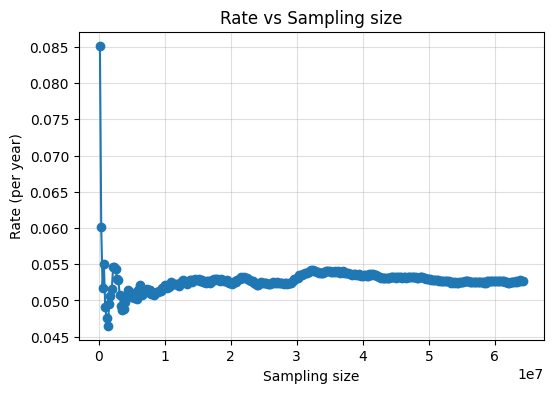

In [43]:
# rate 
meta_data= get_param_from_json("ler_data/meta_lensed_gw_super2.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [44]:
lensed_param_detectable = get_param_from_json("ler_data/n_lensed_params_detectable_gw_super2.json")
# select only events after sampling size of
idx = np.where(meta_data['events_total'] > 5e7)[0]
# take average
gw_rate_lensed = np.mean(meta_data['total_rate'][idx])
print('Lensed GW Rate (per year, sub-threshold considered) =', gw_rate_lensed)

Lensed GW Rate (per year, sub-threshold considered) = 0.0526287620536816


### How many detectable events are there in terms of GRB pdet out of already detected events in terms of GW snr?

In [45]:
lensed_param_detectable = get_param_from_json("ler_data/n_lensed_params_detectable_gw_super2.json")
# get pdet for the lensed events
pdet_lensed,_ = ler.get_lensed_snrs(
    lensed_param=lensed_param_detectable,
    list_of_detectors=['L1','H1','V1'],
    pdet_calculator=grb.pdet_calculator,
)

# only detectable GRBs
num_ =  np.sum(np.sum(pdet_lensed['pdet_net']==1, axis=1)>=2)

In [46]:
# number of detectable events in terms of GRB pdet out of already detected events in term of GW snr
print(f"Number of lensed detectable events in terms of GRB pdet is {num_} \nout of {len(pdet_lensed['pdet_net'])} events that are already detected in terms of GW snr\n")

print(f"if the rate of detectable lensed GWs is {gw_rate_lensed}, \nthen the rate of detectable GRBs is {gw_rate_lensed*num_/len(pdet_lensed['pdet_net'])}\n")

print(f"ratio (lensed detectable GWs)/(lensed detectable GRBs) = {len(pdet_lensed['pdet_net'])/num_}")

Number of lensed detectable events in terms of GRB pdet is 256 
out of 3378 events that are already detected in terms of GW snr

if the rate of detectable lensed GWs is 0.0526287620536816, 
then the rate of detectable GRBs is 0.003988443779083035

ratio (lensed detectable GWs)/(lensed detectable GRBs) = 13.1953125


### Detector horizon calculation for BNS

In [47]:
from gwsnr import GWSNR
gwsnr = GWSNR(
    mtot_max=51,
    ifos=['L1','H1','V1'],
    gwsnr_verbose=False,
)

Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_4.pickle


In [48]:
dhor = gwsnr.detector_horizon(mass_1=1.4, mass_2=1.4, snr_th_net=8)['net'][0]
print(f"Detector Horizon for BNS at SNR=6 is {dhor} Mpc")

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/it]

dl_eff 389.5713941459235
optimal_snr_unscaled [32.91841147]
Detector Horizon for BNS at SNR=6 is 1603.0089314069917 Mpc


## Plot (GW with associated GRB)

In [85]:
# This will be used to plot the viewing angle vs redshift
unlensed_param_detectable = get_param_from_json("ler_data/n_unlensed_params_detectable_gw_super2.json")
zs_gw_unlensed = unlensed_param_detectable['zs']
viewing_angle_grb_unlensed = unlensed_param_detectable['theta_jn']
# radian to degree
viewing_angle_grb_unlensed = np.degrees(viewing_angle_grb_unlensed)
# if angle > 90, then angle = 180 - angle
viewing_angle_grb_unlensed[viewing_angle_grb_unlensed > 90] = viewing_angle_grb_unlensed[viewing_angle_grb_unlensed > 90]-90

In [86]:
lensed_param_detectable = get_param_from_json("ler_data/n_lensed_params_detectable_gw_super2.json")
zs_gw_lensed = lensed_param_detectable['zs']
viewing_angle_grb_lensed = lensed_param_detectable['theta_jn']
# radian to degree
viewing_angle_grb_lensed = np.degrees(viewing_angle_grb_lensed)
# if angle > 90, then angle = 180 - angle
viewing_angle_grb_lensed[viewing_angle_grb_lensed > 90] = viewing_angle_grb_lensed[viewing_angle_grb_lensed > 90]-90

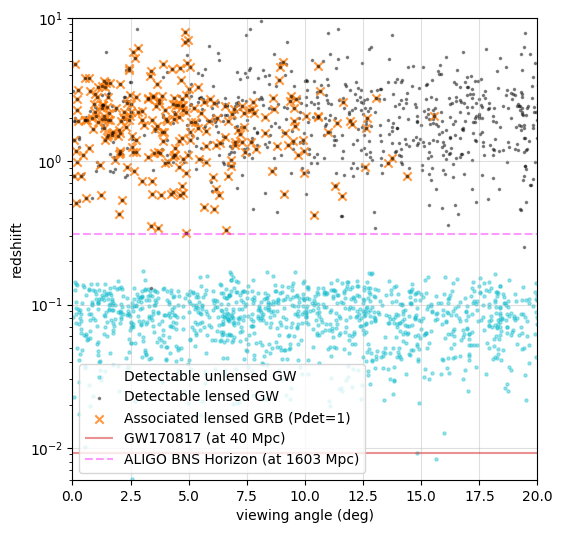

In [87]:
# blue: detection, red: non-detection
# num_ = np.round(len(viewing_angle_grb_lensed)/30)
# idx_ = np.random.choice(len(viewing_angle_grb_lensed), int(num_), replace=False)

plt.figure(figsize=(6,6))

# unlensed GW
plt.scatter(viewing_angle_grb_unlensed, zs_gw_unlensed, c='C9', label="Detectable unlensed GW", alpha=0.4, marker='.', s=20)

# lensed GW
plt.scatter(viewing_angle_grb_lensed, zs_gw_lensed, c='k', label="Detectable lensed GW", alpha=0.4, marker='.', s=10)

# lensed GRB, two or more images pdet=1
idx_ = np.sum(pdet_lensed['pdet_net']==1, axis=1)>=2
plt.scatter(viewing_angle_grb_lensed[idx_], zs_gw_lensed[idx_], c='C1', label="Associated lensed GRB (Pdet=1)", alpha=0.8, marker='x')
plt.scatter(viewing_angle_grb_lensed[idx_], zs_gw_lensed[idx_], c='k', alpha=0.4, marker='.', s=10)

# unlensed GRB, pdet=1
# idx_ = unlensed_grb_pdet['pdet_net']==1
# plt.scatter(viewing_angle_grb_unlensed[idx_], zs_gw_unlensed[idx_], c='r', label="Associated unlensed GW (snr>6)", alpha=0.8, marker='x')
# plt.scatter(viewing_angle_grb_unlensed[idx_], zs_gw_unlensed[idx_], c='C9', alpha=0.9, marker='.', s=10)

# draw a horizontal line for GW170817, 40Mpc
plt.hlines(y=grb.dl_to_z(40), xmin=0, xmax=20, colors='C3', linestyles='solid', label='GW170817 (at 40 Mpc)', alpha=0.5)

# dhor 
plt.hlines(y=grb.dl_to_z(1603), xmin=0, xmax=20, colors='magenta', linestyles='dashed', label="ALIGO BNS Horizon (at 1603 Mpc)", alpha=0.4)

plt.xlabel("viewing angle (deg)")
plt.ylabel("redshiift")
#plt.title("Detectable GRB vs associated detectable GW")
plt.yscale("log")
plt.xlim(0., 20)
plt.ylim(0.006, 10)
plt.legend(loc='lower left')
plt.grid(alpha=0.4)
# save the plot
plt.savefig("gw with associated grb final.png", dpi=400)
plt.show()

### Table for GW rates and associate GRB rates

| Event            | Unlensed | Lensed  | Lensed:Unlensed |
| ---              | ---      | ---     | ---             |
| GW(snr>8)        | 21.07    | 5.26e-2 | 1:400.57        |
| GRB (associated) | 1.91     | 3.99e-3 | 1:478.69        |
| GRB:GW(snr>8)    | 1:11.01  | 1:13.20 | -               |

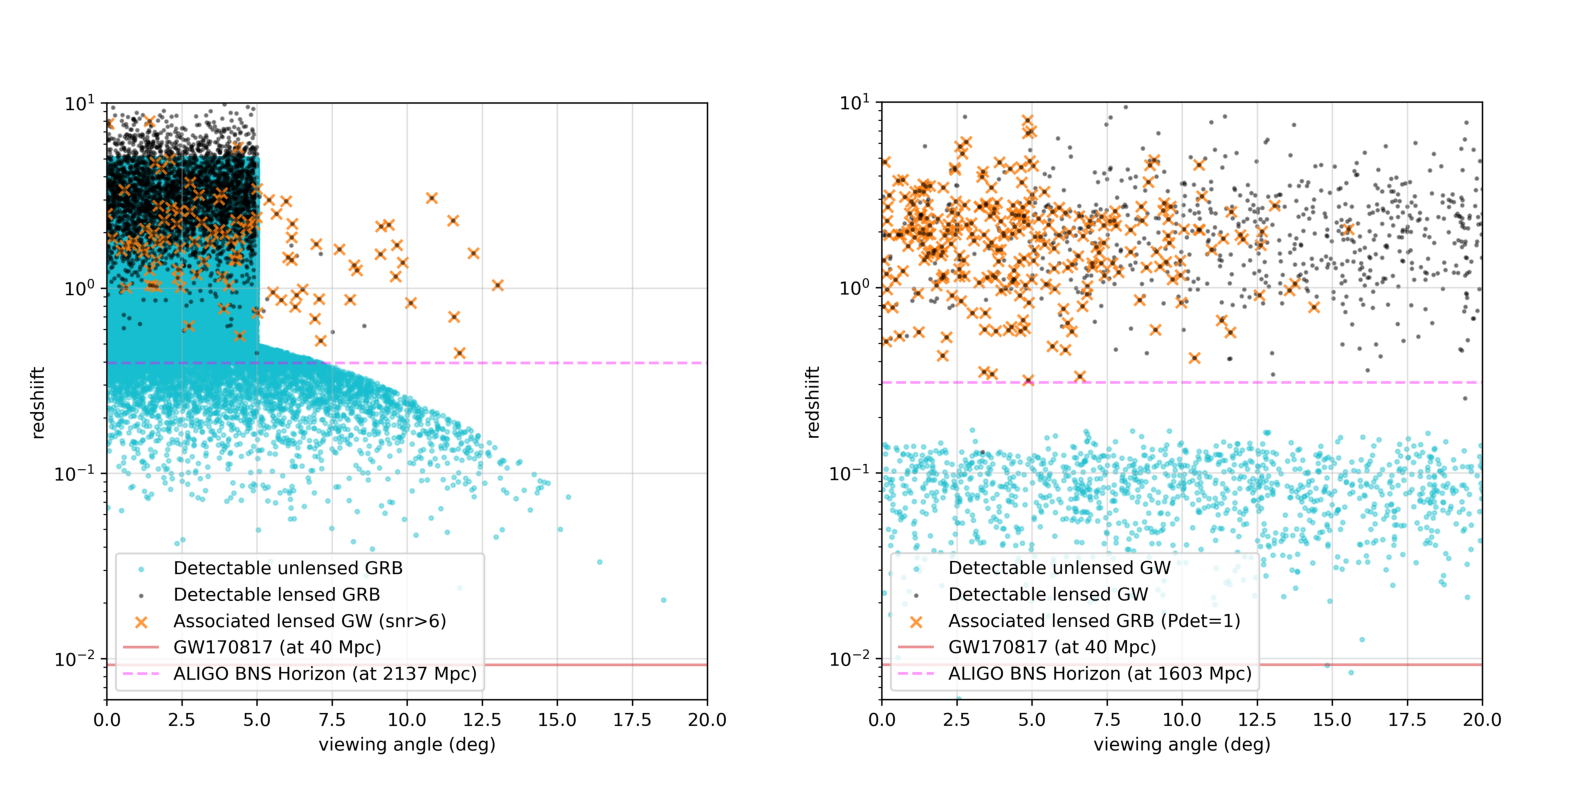

In [90]:
# two plots side by side
fig, axs = plt.subplots(1, 2, figsize=(20,12))
# call png files
img1 = plt.imread("grb with associated gw final.png")
img2 = plt.imread("gw with associated grb final.png")


# plot the images
axs[0].imshow(img1)
axs[0].axis('off')
axs[1].imshow(img2)
axs[1].axis('off')
# increase size of the images
plt.subplots_adjust(wspace=0.0)
# save the plot
plt.savefig("combined final.png", dpi=100)
plt.show()